In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
url = '/content/drive/MyDrive/Soft Computing/'

In [4]:
dataset_2 = url + 'dataset_2_image.zip'
with ZipFile(dataset_2, 'r') as zip:
  zip.extractall()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()

,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [6]:
TRAIN_PATH = url + 'Train_3'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('train')

In [7]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [9]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base Parameters**

In [10]:
batch_size = 85
num_iters = 10000
input_dim = 28*28
num_hidden = 250
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

14


In [16]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:565
Test dataloader:142


In [17]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [18]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=250, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=250, out_features=250, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=250, out_features=250, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=250, out_features=250, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=250, out_features=250, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=250, out_features=250, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=250, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [20]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.29858660697937. Accuracy: 10.425
Epoch:  2
Iteration: 1000. Loss: 2.287616014480591. Accuracy: 24.941666666666666
Epoch:  3
Iteration: 1500. Loss: 2.189692258834839. Accuracy: 40.25833333333333
Epoch:  4
Iteration: 2000. Loss: 1.1051679849624634. Accuracy: 58.69166666666667
Epoch:  5
Iteration: 2500. Loss: 0.7119198441505432. Accuracy: 69.78333333333333
Epoch:  6
Iteration: 3000. Loss: 0.705511748790741. Accuracy: 72.16666666666667
Epoch:  7
Iteration: 3500. Loss: 0.8300613164901733. Accuracy: 73.85833333333333
Epoch:  8
Iteration: 4000. Loss: 0.5454122424125671. Accuracy: 76.45
Iteration: 4500. Loss: 0.7615675926208496. Accuracy: 78.29166666666667
Epoch:  9
Iteration: 5000. Loss: 0.6397309899330139. Accuracy: 79.44166666666666
Epoch:  10
Iteration: 5500. Loss: 0.3646920621395111. Accuracy: 79.425
Epoch:  11
Iteration: 6000. Loss: 0.3938906192779541. Accuracy: 81.925
Epoch:  12
Iteration: 6500. Loss: 0.5164027810096741. Accuracy: 82.29166666666667
Epoc

In [21]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Soft Computing/model_base.pkl')

[2.29858660697937, 2.287616014480591, 2.189692258834839, 1.1051679849624634, 0.7119198441505432, 0.705511748790741, 0.8300613164901733, 0.5454122424125671, 0.7615675926208496, 0.6397309899330139, 0.3646920621395111, 0.3938906192779541, 0.5164027810096741, 0.42271867394447327, 0.5954871773719788]


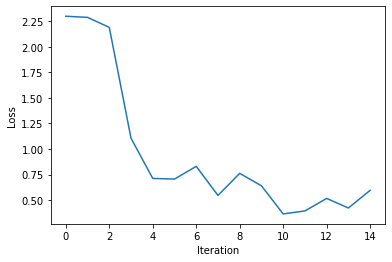

In [22]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()